In [1]:
# import packages needed for entire model

import tensorflow as tf
from keras import layers
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import regularizers
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from keras.backend import softsign
import shutil
import random
from keras import metrics
import sys
import h5py

# mount to google drive in order to pull data file
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
terminal = sys.stdout

Mounted at /content/drive


In [ ]:
# import data file, splice data, split into testing and training data
test = 1
subsetSize= 89000
validationSize = 2000
splicingVal = 11
numOutputs = int(220/splicingVal)

file = "/content/drive/My Drive/Colab Notebooks/dataset_comp_image_spectra.h5"
hf = h5py.File(file, 'r')
#sample = hf["sample_id"][0:subsetSize + validationSize]
imgs = hf['images'][subsetSize*test:subsetSize*(test+1) + validationSize]
spectra = hf['spectra'][subsetSize*test:subsetSize*(test+1) + validationSize]
spectra = np.array([x[::splicingVal] for x in spectra])
imgsNN = imgs[0:subsetSize]
spectraNN = spectra[0:subsetSize]
x_valid = imgs[subsetSize:subsetSize+validationSize]
y_valid = spectra[subsetSize:subsetSize+validationSize]
x_train, x_test, y_train, y_test = train_test_split(imgsNN, spectraNN, test_size = 0.2, random_state = None)

In [ ]:
# Current Neural Network Model function

def get_conv_model_normal():

    model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(units=numOutputs, activation = 'softsign')])
    model.summary()
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [ ]:
# Running Neural Network with averaging Ensemble

# Define number of networks, batches, and epochs 
numNetworks = 2
epochs = 50
batch_size = 32
startNetworkVal = 0

# Run Neural Network for the desired number of networks in the ensemble (numNetworks)
sys.stdout = open('EpochOutput.txt', 'w')
modelList = []
historyList= []
for i in range(startNetworkVal, startNetworkVal + numNetworks):
  name = f'model_{i}.h5'
  gdrive_link = "/content/drive/My Drive/Colab Notebooks/Models/Training Folder"
  if test == 0:
    normal_model = get_conv_model_normal()
  else:
    normal_model = tf.keras.models.load_model(f'{gdrive_link}/{name}')
  early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
  temp = list(zip(x_train, y_train))
  random.shuffle(temp)
  x_train, y_train = zip(*temp)
  normal_history = normal_model.fit(x_train, y_train, batch_size = batch_size,
                epochs = epochs, validation_data = (x_test, y_test), verbose = 1,
                callbacks=[early_stopping])
  modelList.append(normal_model)
  historyList.append(normal_history)
  normal_model.save(name)
  colab_link = name
  shutil.copy(colab_link, gdrive_link)
sys.stdout = terminal
    
# Create predictions based on results of the neural network and ensemble 
def makePredictionsList(modelList, data):
  return [model.predict(data) for model in modelList]

# Create the geometric average of the output spectra from the predicted values from the ensemble
def ensemblePredictGeoAverage(predictList, ele):
  numNetworks = len(predictList)
  prediction = 1
  for predict in predictList:
    prediction *= np.abs(predict[ele])
  return prediction**(1/numNetworks)

In [ ]:
# DO NOT RUN
# Attempted neural network for the outcomes of the ensemble, returned bad graphs so scratched for now, may implement later

def get_model_from_ensemble():
    model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (numNetworks, numOutputs)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(units=20, activation='softsign')
    ])
    model.summary()
    model.compile(loss = tf.keras.losses.MeanSquaredLogarithmicError(), optimizer = 'adam', metrics = [metrics.mean_squared_logarithmic_error, metrics.mean_absolute_percentage_error]))
    return model

# fixed input parameters
modelInput = makePredictionsList(modelList, x_train)
modelInput = np.transpose(modelInput, (1, 0, 2))

sys.stdout = open('EpochOutput2.txt', 'w') 
epochs = 50
batch_size = 64
x_train2, x_test2, y_train2, y_test2 = train_test_split(modelInput, spectra, test_size = 0.2, random_state = None)
final_model = get_model_from_ensemble()
final_history = final_model.fit(x_train2, y_train2, batch_size = batch_size,
              epochs = epochs, validation_data = (x_test2, y_test2), verbose = 1)
sys.stdout = terminal

# Plots to visualize the mean squared logarithmic error and mean absolute percentage error of our final neural network ensemble model

# MSLE
plt.plot(final_history.history['mean_squared_logarithmic_error'], label='MSLE training data')
plt.plot(final_history.history['val_mean_squared_logarithmic_error'], label='MSLE validation data')
plt.legend()
plt.title('Mean Squared Logarithmic Error Over Time')
plt.ylabel('MSLE')
plt.xlabel('epoch')
plt.savefig('ModelAccuracyMSLE.jpg')
plt.show()

# MAPE
plt.plot(final_history.history['mean_absolute_percentage_error'], label='MAPE training data')
plt.plot(final_history.history['val_mean_absolute_percentage_error'], label='MAPE validation data')
plt.legend()
plt.title('Mean Absolute Percentage Error Over Time')
plt.ylabel('MAPE')
plt.xlabel('epoch')
plt.savefig('ModelAccuracyMAPE.jpg')
plt.show()

In [ ]:
# Plots to visualize the mean squared logarithmic error and mean absolute percentage error of our neural network ensemble model

# RMSE
fig = plt.figure(figsize=(25, 5))
prevEpoch = 29
for i, normal_history in enumerate(historyList):
  y = normal_history.history
  epoch = len(y['mean_squared_error'])
  x = np.array([x for x in range(epoch)])
  plt.plot(x + prevEpoch*i, y['mean_squared_error'], color = 'b')
  plt.plot(x + prevEpoch*i, y['val_mean_squared_error'], color = 'y')
  plt.plot([prevEpoch*(i+1),prevEpoch*(i+1)],[0,.1], color='black')
  plt.title('Mean Squared Error(MSE) Over Time')
  plt.ylabel('MSE')
  plt.xlabel('Epoch')
  prevEpoch = epoch
plt.legend(['MSE training data', 'MSE validation data'])
plt.savefig('MSE_Plot.jpg')
plt.plot([0,0],[0,.1], color = 'black')
plt.show()


In [ ]:
for i, normal_history in enumerate(historyList):
  x = epochs
  plt.plot(normal_history.history['mean_squared_error'], color = 'b')
  plt.plot(normal_history.history['val_mean_squared_error'], color = 'y')
  plt.title('Mean Squared Error(MSE) Over Time')
  plt.ylabel('MSE')
  plt.xlabel('Epoch')
plt.show()
plt.legend(['MSE training data', 'MSE validation data'])
plt.savefig('MSE_Plot.jpg')


In [ ]:
# Plots first 10 spectra images on a single graph
x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_valid)
y = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))]
fig = plt.figure(figsize=(25, 5))
for i in range(10):
  plt.plot(x + 220*i, y[i] , color = 'y')
  plt.plot(x + 220*i, y_test[i], color = 'b')
  plt.legend(['predict', 'actual'], loc='upper left')
plt.title('First 10 spectras')
plt.savefig('First10.jpg')
plt.show()

# Plots random 10 spectra images on a single graph
rando = [x for x in range(10, len(y))]
random.shuffle(rando)
i = 0
fig = plt.figure(figsize=(25, 5))
for rand in rando:
  if i > 10:
    break
  plt.plot(x + 220*i, y[rand], color = 'y')
  plt.plot(x + 220*i, y_test[rand], color = 'b')
  plt.legend(['predict', 'actual'], loc='upper left')
  i+=1
plt.title('Random 10 spectras')
plt.savefig('Random10.jpg')
plt.show()

In [ ]:
# Creates Grid of All Spectras in Testing set

def closest_factor(num):
  n = int(np.sqrt(num))
  if num % n == 0:
    return n
  else:
    n+=1
    while num % n != 0:
      n+=1
    return int(num/n), n

x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_test)
y = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_test))]
fig = plt.figure(figsize=(25, 50))
low, high = closest_factor(len(x_test))
for j in range(low):
  for i in range(high):
    plt.plot(x + 220*i, y[50*j+i]+.5*j, color = 'y')
    plt.plot(x + 220*i, y_test[50*j+i]+.5*j, color = 'b')
plt.legend(['predict', 'actual'], loc='upper left', prop={'size': 24})
plt.title('Each Individual Spectra')
plt.savefig('EverySpectra.jpg')
plt.show()

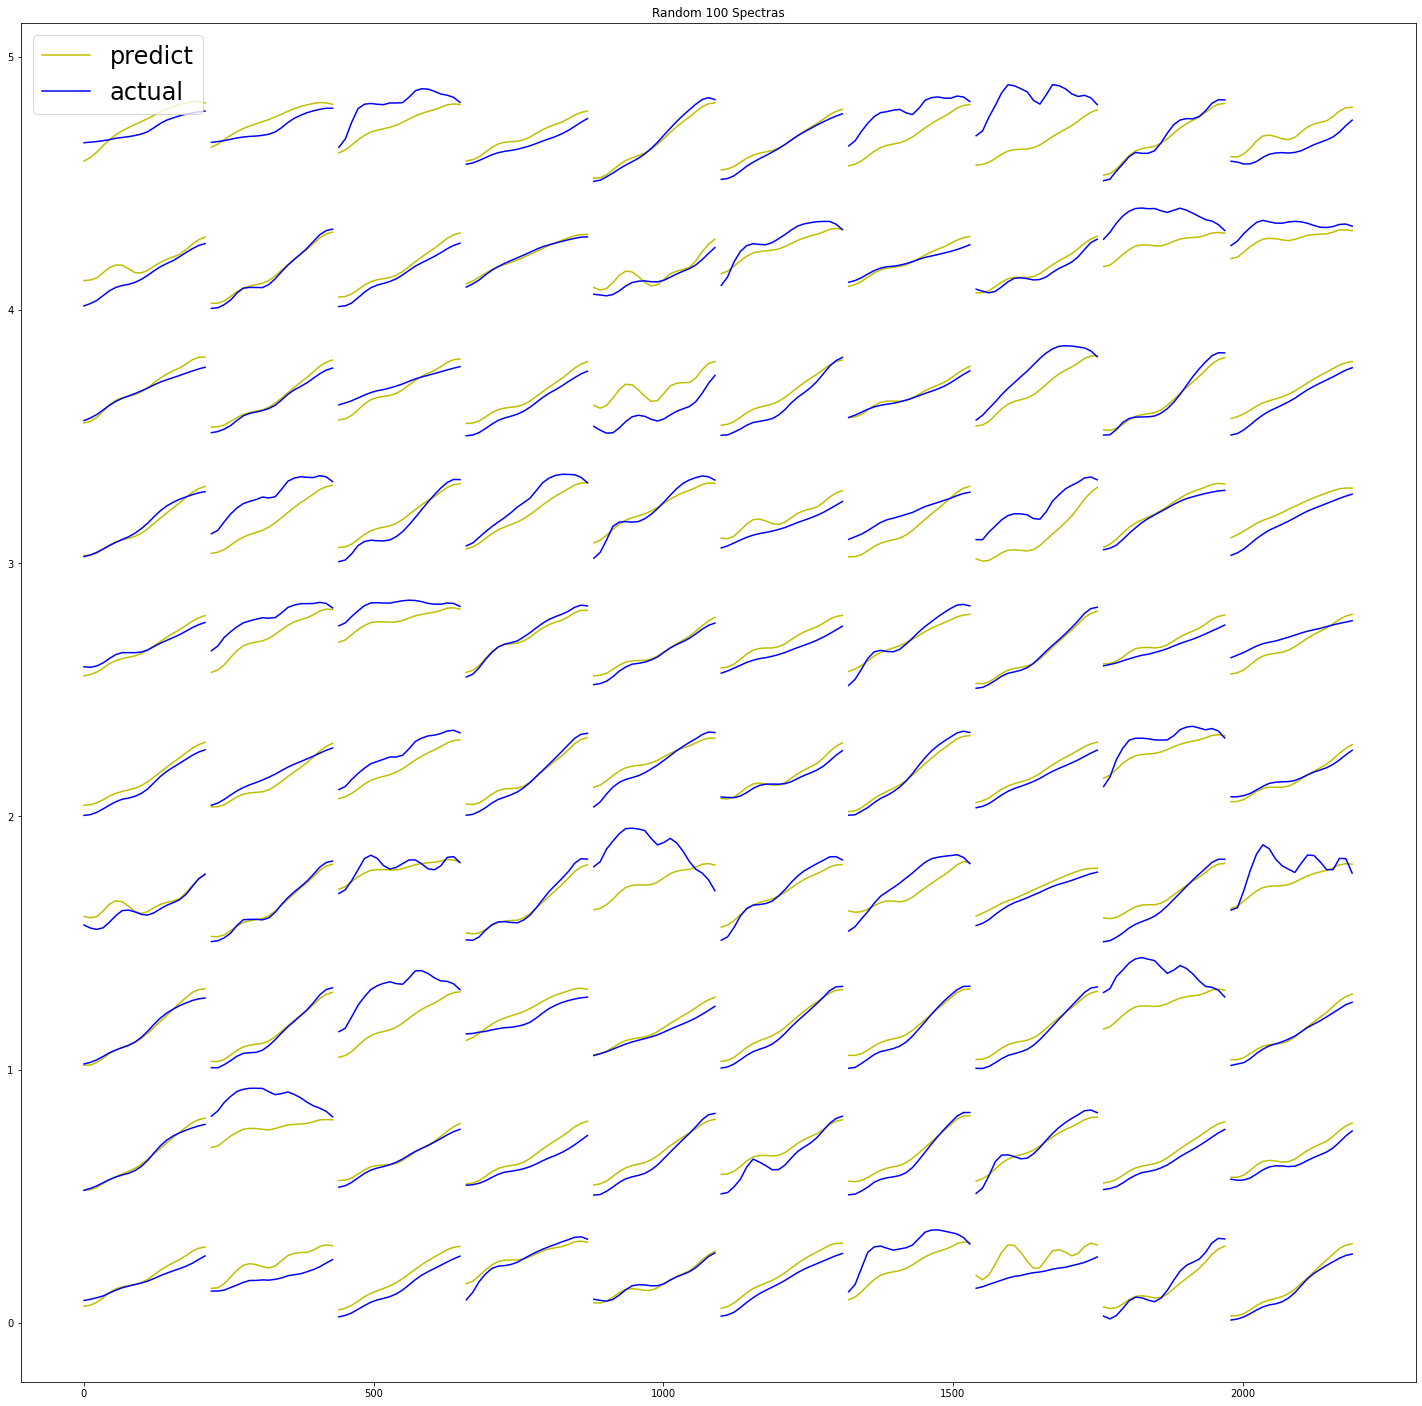

In [ ]:
# Creates Random 100 Grid of Spectras from Validation Data
x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_valid)
y = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))]
rando = [x for x in range(len(y))]
random.shuffle(rando)
fig = plt.figure(figsize=(25, 25))
for j in range(10):
  for i in range(10):
    rand = rando[10*j + i]
    plt.plot(x + 220*i, y[rand]+.5*j, color = 'y')
    plt.plot(x + 220*i, y_valid[rand]+.5*j, color = 'b')
    i+=1
plt.legend(['predict', 'actual'], loc='upper left', prop={'size': 24})
plt.title('Random 100 Spectras')
plt.savefig('100Grid.jpg')
plt.show()

In [ ]:
# Make Error graph
from sklearn.metrics import r2_score
predictList = makePredictionsList(modelList, x_valid)
y_pred = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))]
fig, axe = plt.subplots(figsize=(15, 15), dpi=300)
for i in range(numOutputs):
  x = np.transpose(y_valid)[i]
  for model in range(numNetworks):
    plt.plot(x, np.transpose(predictList[model])[i], '.', alpha=0.5, color = 'b', label = 'Individual Networks')
for i in range(numOutputs):
  x = np.transpose(y_valid)[i]
  plt.plot(x, np.transpose(y_pred)[i], '.', alpha=0.5, color = 'y', label = 'Ensemble Network')
a, b = 0, .4 
plt.plot([a,b],[a,b], color='black')
plt.title('Symmetric Error Graph')
plt.xlabel('y actual')
plt.ylabel('y predicted')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), prop={'size': 24})
font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 16}
axe.text(.425, 0.4, f"R^2 = {round(r2_score(np.array(y_pred).flatten(), np.array(y_valid).flatten()), 5)}", fontdict = font)
plt.savefig('SymError.jpg')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

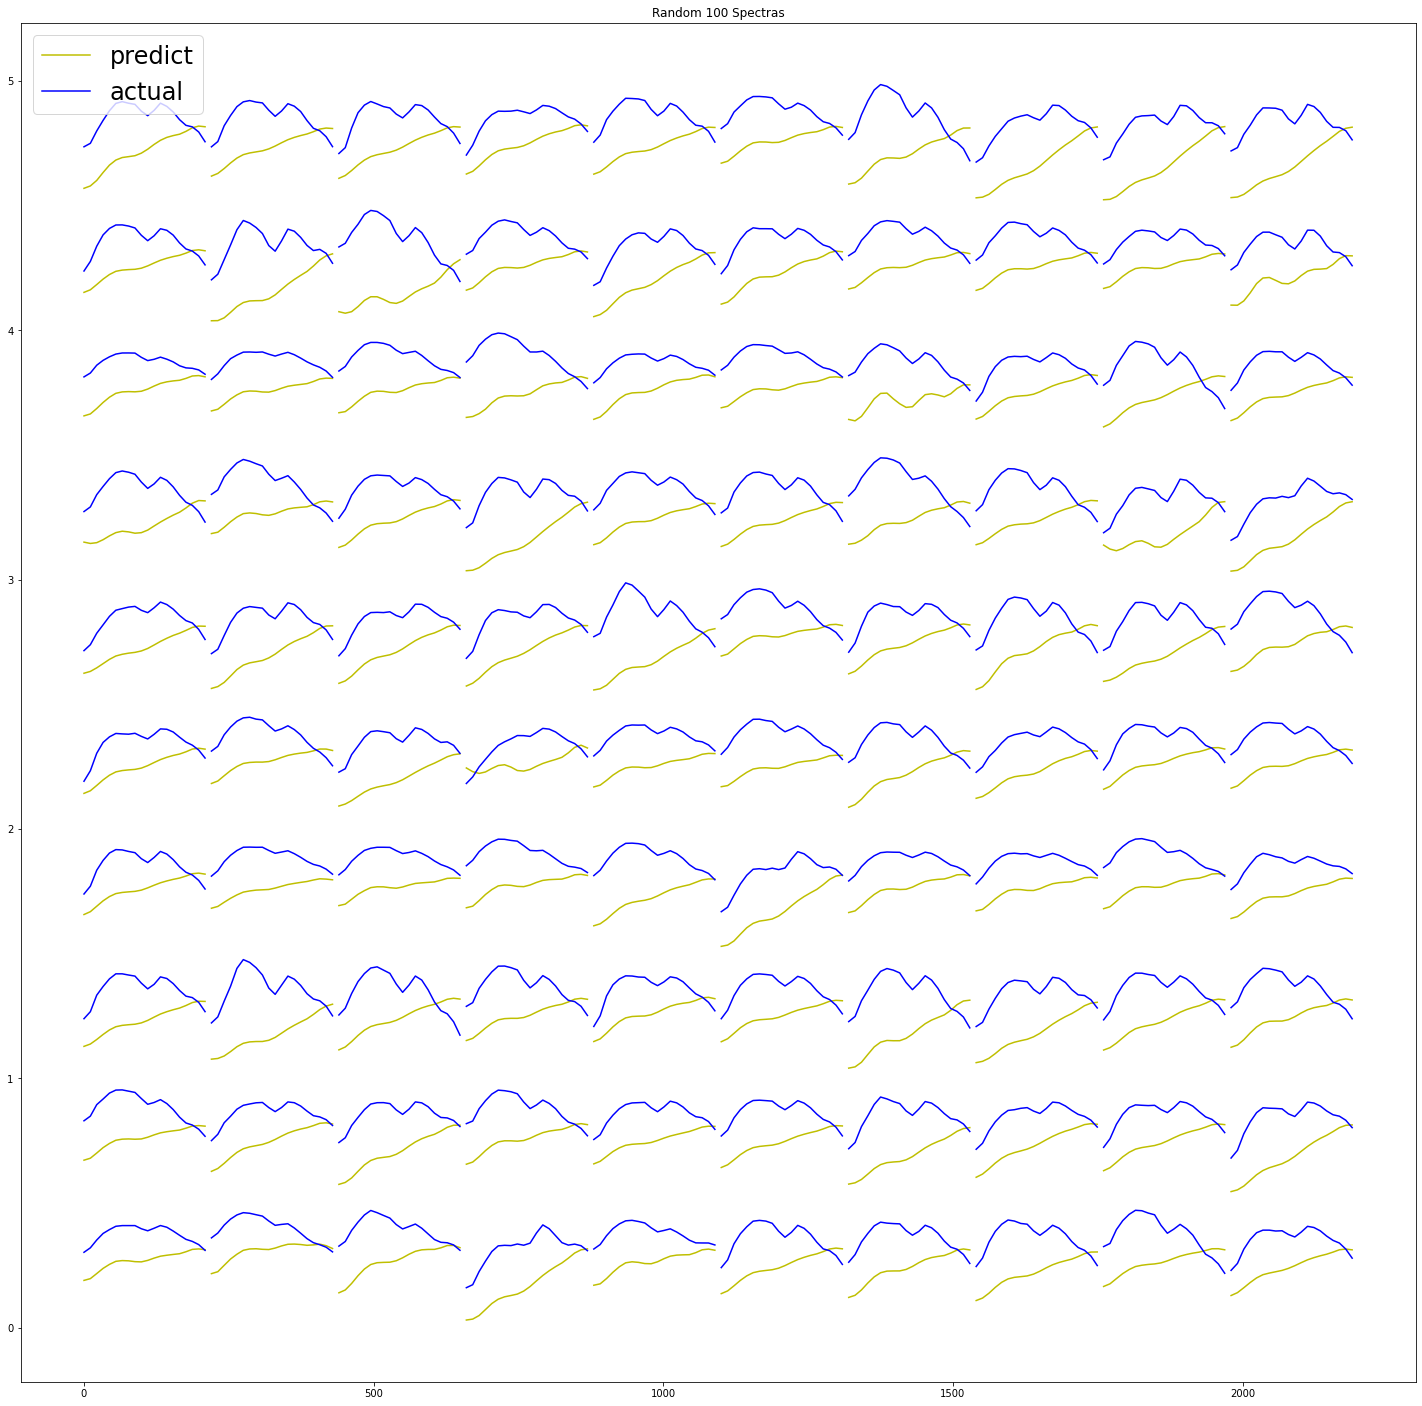

IndexError: ignored

In [ ]:
bad = []
y = []
indexList = []
for i, ele in enumerate(y_valid):
  if max(ele) >= .4:
    bad.append(y_pred[i])
    y.append(ele)
    indexList.append(i)
# Creates Random 100 Grid of Spectras from Validation Data
x = np.array([x for x in range(0,220,splicingVal)])
fig = plt.figure(figsize=(25, 25))
#low, high = closest_factor(len(bad))
for j in range(10):
  for i in range(10):
    try:
      plt.plot(x + 220*i, bad[i+10*j]+.5*j, color = 'y')
      plt.plot(x + 220*i, y[i+10*j]+.5*j, color = 'b')
    except: 
      break
plt.legend(['predict', 'actual'], loc='upper left', prop={'size': 24})
plt.title('Random 100 Spectras')
plt.savefig('100Grid.jpg')
plt.show()

def nonZeroInList(arr):
  returnList = []
  for i, ele in enumerate(arr):
    if ele > 0.0:
      returnList.append([hf['atfrac_keys'][i], i, ele])
  return returnList
  
def frequencyOfItems(arr):
  frequency = {}
  for item in arr:
    if str(item) in frequency:
        frequency[str(item)] += 1
    else:
        frequency[str(item)] = 1
  return frequency
iter = 0
oxideList = []
for index in indexList:
  metal = np.transpose(hf['atfrac'])[subsetSize + index][0:42]
  #print(iter, nonZeroInList(metal))
  oxideList.append(nonZeroInList(metal))
  iter += 1
sort = sorted(oxideList, key = lambda oxide: (oxide[0][1], len(oxide), oxide[0][2]))
for each in sort:
  print(each)
print('----')
for key, value in frequencyOfItems(sort).items():
  print(f'{key}: {value}')


In [ ]:
#Make error graph 2
predictList = makePredictionsList(modelList, x_valid)
y_pred = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))]
fig = plt.figure(figsize=(15, 10))
for i in range(len(x_valid)):
  plt.plot(y_valid[i] - y_pred[i], '*', color = 'b')
plt.plot([0, numOutputs - 1],[0,0], color = 'black')
plt.title('Point-Wise Error')
plt.savefig('PointWiseError.jpg')
plt.show()

In [ ]:
x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_train)
y = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_train))]
plt.plot(x,spectra[0], color = 'b')
for predict in predictList:
  plt.plot(x, predict[0], color = 'y')
  plt.plot(x,y[0], color = 'black')
plt.legend(['Actual', 'Ensemble Predictions', 'Avg Prediction'], loc = 'upper left')
plt.title('Comparison of Predictions')
plt.ylabel('Spectra')
plt.savefig('PredictCompare.jpg')
plt.show()

In [ ]:
# Various error functions to use
y0 = y_test
predictList = makePredictionsList(modelList, x_test)
y1 = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_test))]

dy = y0-y1 # error 
abs_dy = np.abs(y0-y1)    # absolute error 
relerr = np.abs(y0-y1)/y0   # relative error 
pererr = np.abs(y0-y1)/y0*100    # percentage error 
mean_err = np.mean(np.abs(y0-y1))     # mean absolute error 
MSE = np.mean((y0-y1)**2)        # Mean square error 
RMSE = np.sqrt(np.mean((y0-y1)**2))  # Root mean square error

In [ ]:
# Saving Code Block: uploads models under names to google drive, must move these to the Shared Drive

names = ['EpochOutput.txt', 'First10.jpg', 'Random10.jpg', 'ModelAccuracyMSLE.jpg', 'ModelAccuracyMAPE.jpg', 'PredictCompare.jpg', '100Grid.jpg', 'EverySpectra.jpg', 'SymError.jpg', 'PointWiseError.jpg', 'MSE_Plot.jpg']
for name in names:
  try:
    colab_link = name
    gdrive_link = "/content/drive/My Drive/Colab Notebooks/Models"
    shutil.copy(colab_link, gdrive_link)
  except:
    print(f'{name} not downloaded')

In [ ]:
# DO NOT RUN
# Plots First 10 predictions all on the same graph
# Only use if you need to investigate oscillations in spectra graphs
# Must add 'AllPredictions.jpg' to saving code block for this image to save

x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_train)
y = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_train))]
fig = plt.figure(figsize=(25, 5))
for i in range(10):
  plt.plot(x, y[i] , color = 'y')    
  plt.legend(['predict'], loc='upper left')  
plt.savefig('AllPredictions.jpg')
plt.show()

In [ ]:
# DO NOT RUN
# Attempt to implement Custom Loss Function, still a work in progress

def custom_loss(y_true, y_pred):
  #shape of y_true/y_pred = (batchSize, numOutputs)
  #distance metric
  lossDistance = tf.square(y_pred - y_true)
  return lossDistance
  #smoothness metric
  Deriv2 = 0
  for batch in range(batchSize):
    for i in range(numOutputs):
      if i == numOutputs - 3:
        break
      Deriv2 += 1

def SMU(x,alpha=0.25):
    mu = tf.compat.v1.get_variable('SMU_mu', shape=(),
                       initializer=tf.constant_initializer(1000000),
                       dtype=tf.float32)
    return ((1+alpha)*x + (1-alpha)*x*tf.math.erf(mu*(1-alpha)*x))/2

def SMU1(x,alpha=0.25):
    mu = tf.compat.v1.get_variable('SMU1_mu', shape=(),
                       initializer=tf.constant_initializer(4.352665993287951e-9),
                       dtype=tf.float32)
    return ((1+alpha)*x+tf.math.sqrt(tf.math.square(x-alpha*x)+tf.math.square(mu)))/2

from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

#get_custom_objects().update({'SMU': Activation(SMU)}) 
#get_custom_objects().update({'SMU1': Activation(SMU1)}) 

In [ ]:
# DO NOT RUN 
# Use this only if we want to load an already built model
normal_model = load_model('Model.h5')